In [2]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint

In [3]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_geometries as gij
import b_spin_ops as su2
import c_maxent_tools as me

In [5]:
params={}

params['size']=5
params['beta']=5.

params['w']=2.*np.pi*1.; params['Jx'] = 50 * 10**-30 * params['w']; params['Jy'] = .5*params['Jx']
params['chain_type']='XY'
params['Omega']=params['w']; params['V0']=1.2; params['phase'] = 0
params['period']=2.*np.pi/params['Omega']

print(params['V0']/params['Omega'])

0.1909859317102744


In [6]:
spin_ops=su2.one_body_spin_ops(args=params)

sx_total=sum(sx for sx in spin_ops['sx'])
sy_total=sum(sy for sy in spin_ops['sy'])
sz_total=sum(sz for sz in spin_ops['sz'])

H0 = params['w']*sz_total
Hint=1.*su2.Heisenberg_1D_Hamiltonian(args=params, spin_ops=spin_ops)

### Exact lab Hamiltonian
driving_td = lambda t,args: args['V0']*np.cos(args['Omega']*t+args['phase'])
Hlab=[H0+Hint, [sx_total, driving_td]]

### RWA Hamiltonian
Hrwa=H0-params['Omega']*sz_total
Hrwa+= Hint
Hrwa+=.5*params['V0']*(np.cos(params['phase'])*sx_total + 
                          np.sin(params['phase'])*sy_total)

### Rotated Hamiltonian (RWA+cr terms)
rot_sx_tdterm=lambda t,args: .5*(np.cos(2*args['Omega']*t+args['phase']))
rot_sy_tdterm=lambda t,args: -.5*(np.sin(2*args['Omega']*t+args['phase']))

Hrwa_cr=[Hrwa, [sx_total, rot_sx_tdterm], [sy_total, rot_sy_tdterm]]

In [7]:
### as functions

func_Hex=lambda t,args: H0+Hint+driving_td(t=t,args=args)*sx_total

In [9]:
HBB0=[spin_ops['idop'],sx_total, sy_total, sz_total]
phi0=[.0, 0.,.1,-5.]; beta=1/params['beta']
K0=-sum(phi*op for phi,op in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K0)
phi0[0]=np.log(sigma0.tr())
K0=-sum(phi*op for phi,op in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K0)

HBB0+=[K0]

In [10]:
params['Jx']/params['Omega']

5.0000000000000004e-29

In [11]:
N=300
T=4*np.pi/max(.001,abs(params['V0']))/N
timespan = np.linspace(0,N*T,N)

resex=qutip.mesolve(H=[H0+Hint, [sx_total, driving_td]],
                    rho0=K0,
                    tlist=timespan,
                    args=params)

resrwa=qutip.mesolve(H=Hrwa,
                     rho0=K0,
                     tlist=timespan,
                     args=params)

resrwacr=qutip.mesolve(H=Hrwa_cr,
                       rho0=K0,
                       tlist=timespan, 
                       args=params) 

U_rwa = lambda t,args: (-1j*sz_total*args['Omega']*t).expm()
U_rwa_td=[U_rwa(t=ti,args=params) for ti in timespan]
exact_Ks_labframe=[U_rwa_ti.dag() * Kti * U_rwa_ti for U_rwa_ti,Kti in zip(U_rwa_td,resex.states)]
rot_Ks_labframe=[U_rwa_ti.dag() * Krotti * U_rwa_ti for U_rwa_ti, Krotti in zip(U_rwa_td,resrwacr.states)]

rhos_resrwa=[gij.safe_expm_and_normalize(K=Kt) for Kt in resrwa.states]
rhos_resex=[gij.safe_expm_and_normalize(K=Kti) for Kti in exact_Ks_labframe]
rhos_rotcr=[gij.safe_expm_and_normalize(K=Kti) for Kti in rot_Ks_labframe]

In [12]:
ds=[0,1,2]
sigmas_maxent, Ks_maxent=me.multiple_projections(
                             exact_Ks=resrwa.states,
                             exact_states=rhos_resrwa,
                             generator=Hrwa, K0=K0,
                             basis0=HBB0,
                             depths=ds,
                             timespan=timespan,
                             args=params)

NameError: name 'Error' is not defined

C:\Users\tomas\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tomas\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


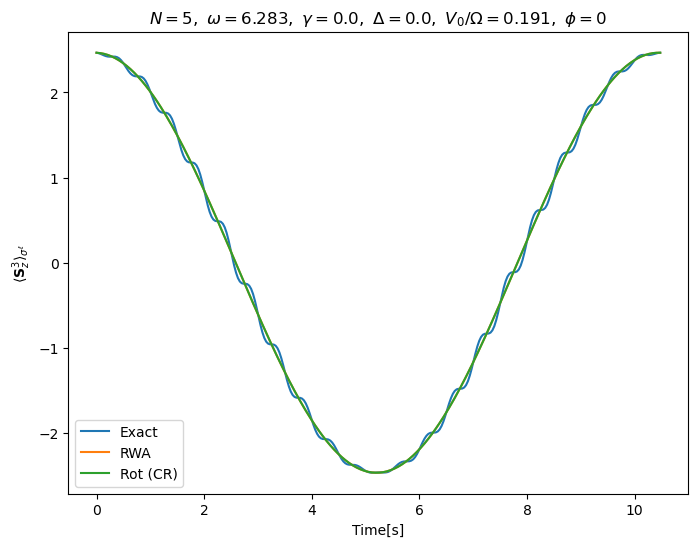

In [10]:
sz_tot_evex=np.array([(rho*sz_total).tr() for rho in rhos_resex])
sz_tot_evrwa=np.array([(sigma*sz_total).tr() for sigma in rhos_resrwa])
sz_tot_evrot=np.array([(sigma*sz_total).tr() for sigma in rhos_rotcr])
sz_tot_maxent=[np.array([(sigma_ell*sz_total).tr() for sigma_ell in sigmas_maxent_ell1]) 
                                                  for sigmas_maxent_ell1 in sigmas_maxent]

fig0,ax0=plt.subplots(figsize=(8,6))

plt.plot(timespan, sz_tot_evex, label='Exact')
plt.plot(timespan, sz_tot_evrwa, label='RWA')
plt.plot(timespan, sz_tot_evrwa, label='Rot (CR)')
#for d in ds: 
#    plt.plot(timespan, sz_tot_maxent[ds.index(d)], label='RWA-HB d='+str(d))
ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle {\bf S}_z^3 \rangle_{\sigma^\ell}$")
plt.title(r'$N={},\,\,\omega={},\,\, \gamma={},\,\, \Delta={},\,\, V_0/\Omega={}, \,\, \phi={}$'.format(
                                                                params['size'],
                                                                round(params['w'],3), 
                                                                round((params['Jx']-params['Jy']),3), 
                                                                round(params['w']-params['Omega'],3), 
                                                                round(params['V0']/params['Omega'],3),
                                                                round(params['phase'],2)))
plt.show()

## Lieb-Robinson

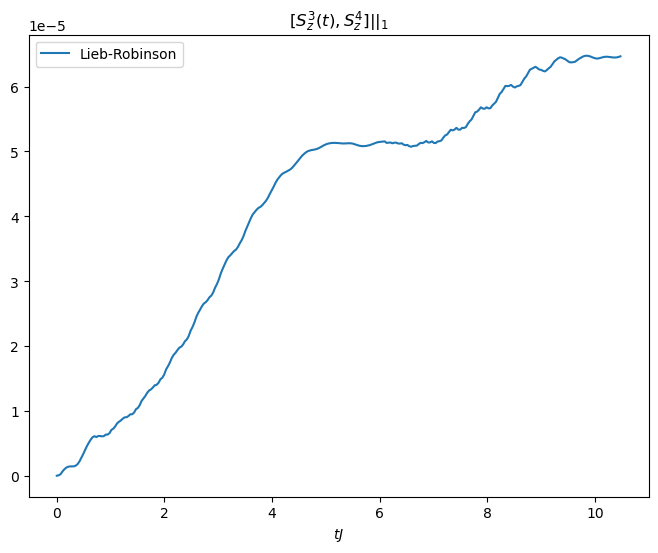

In [33]:
Uex_timet=qutip.propagator(H=Hlab, t=timespan, args=params)
sz3_timet=[Uex_tti.dag()*spin_ops['sz'][3]*Uex_tti for Uex_tti in Uex_timet]
Ob=spin_ops['sz'][4]
lieb_robinson=np.array([linalg.norm(gij.commutator(sz3_tti,Ob)) for sz3_tti in sz3_timet])

fig,ax0=plt.subplots(figsize=(8,6))
plt.plot(timespan, lieb_robinson, label='Lieb-Robinson')
plt.title(f'$[S_z^3(t), S_z^4]||_1$')
plt.xlabel(f'$tJ$')
ax0.legend(loc=0)
plt.plot()
plt.show()

In [ ]:
lieb_robinson=gij.commutator()

In [121]:
params['Jx']/params['Omega']

5.0000000000000004e-29

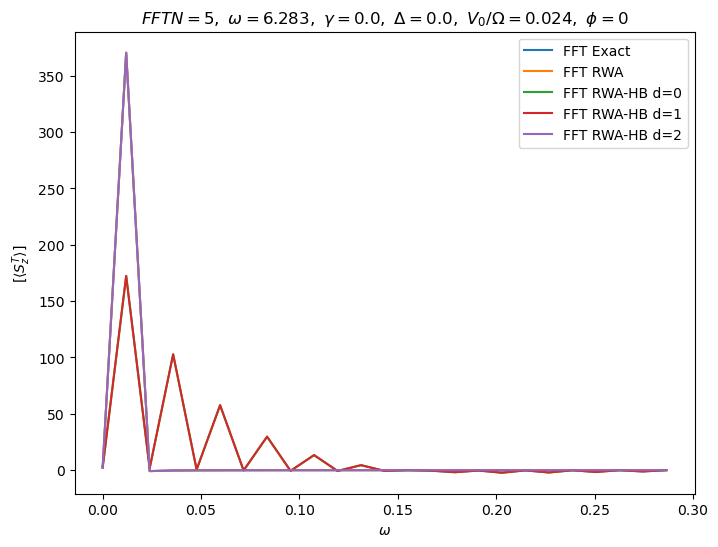

In [124]:
from scipy.fft import fft, fftfreq

xf=fftfreq(N, T)[:N//2]
fft_sz_tot_evex = fft(sz_tot_evex)[:N//2]
fft_sz_tot_evrwa = fft(sz_tot_evrwa)[:N//2]
fft_sz_tot_maxent = [fft(data)[:N//2] for data in sz_tot_maxent]

fig0,ax0=plt.subplots(figsize=(8,6))

plt.plot(xf[:25], fft_sz_tot_evex[:25], label='FFT Exact')
plt.plot(xf[:25], fft_sz_tot_evrwa[:25], label='FFT RWA')
for d in ds:    
    plt.plot(xf[:25], fft_sz_tot_maxent[ds.index(d)][:25], label='FFT RWA-HB d='+str(d))
ax0.legend(loc=0)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$[\langle S_z^T\rangle]$')
plt.title(r'$FFT N={},\,\,\omega={},\,\, \gamma={},\,\, \Delta={},\,\, V_0/\Omega={}, \,\, \phi={}$'.format(
                                                                params['size'],
                                                                round(params['w'],3), 
                                                                round((params['Jx']-params['Jy']),3), 
                                                                round(params['w']-params['Omega'],3), 
                                                                round(params['V0']/params['Omega'],3),
                                                                round(params['phase'],2)))
plt.show()